In [1]:
import os
import numpy as np
from datetime import datetime
import learning_lidar.utils.global_settings as gs
import learning_lidar.utils.vis_utils as vis_utils
import pandas as pd
import learning_lidar.preprocessing.preprocessing as prep
import learning_lidar.preprocessing.preprocessing_utils as prep_utils
from learning_lidar.generation.daily_signals_generations_utils import  calc_poiss_measurement,calc_range_corr_measurement
import learning_lidar.generation.generation_utils as gen_utils
import learning_lidar.dataseting.dataseting as dataseting
import learning_lidar.utils.xr_utils as xr_utils
import xarray as xr
vis_utils.set_visualization_settings()
import matplotlib.pyplot as plt
%matplotlib inline

fast_funcs not available


# 1. Set parameters

In [4]:
station_name = 'haifa'
station = gs.Station(station_name)
wavelengths = gs.LAMBDA_nm().get_elastic()

main_folder = os.path.dirname(os.path.abspath(os.path.curdir))
data_folder = os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(os.path.curdir))), 'data')
data_folder

'C:\\Users\\addalin\\Dropbox\\Lidar\\lidar_learning\\data'

# 2. Calculate poisson on "clear" signals, without background, for the given period.
Adding range corrected with applies poisson noise to signal database
# TODO: ADD this to generation.py

In [5]:
start_date = datetime(2017, 9, 1)
end_date = datetime(2017, 10, 31)
dates = pd.date_range(start_date,end_date,freq='D')

In [6]:
CALC_STATS=False
if CALC_STATS:
    base_folder = station.gen_signal_dataset
    paths = [os.path.join(prep.get_month_folder_name(base_folder, dt),
     gen_utils.get_gen_dataset_file_name(station, dt, data_source='signal')) for dt in dates]
    mean = np.zeros(3)
    std = np.zeros(3)
    norm_scale = 1 / len(dates)

    for cur_date,nc_path in zip(dates,paths):
        signal_ds = prep.load_dataset(nc_path)
        signal_ds
        pn_ds = calc_poiss_measurement(station, cur_date, signal_ds.p)  # lidar measurement: pn ~Poiss(mu_p)
        pr2n_ds = calc_range_corr_measurement(station, cur_date, pn_ds, signal_ds.r2) # range corrected measurement: pr2n = pn * r^2
        pr2n_ds.attrs['info']+=' - w.o. background'
        mean += pr2n_ds.mean(dim={'Height', 'Time'}).values
        std += pr2n_ds.std(dim={'Height', 'Time'}).values
        signal_ds = signal_ds.assign(range_corr_p =pr2n_ds)
        gen_utils.save_generated_dataset(station, signal_ds,
                                         data_source='signal',
                                         save_mode='both',
                                         profiles=['range_corr_p'])

    mean *= norm_scale
    std *= norm_scale

# 3. Statistics for a period of the dataset
> Loading the statistics database created in dataseting.py
# TODO: ADD this to statistics calculation
# TODO: ADD `range_corr_p` as  column to dataseting.py (gen_csv)

In [6]:
stats_fname = f"stats_gen_{station.name}_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}.csv"
csv_stats_path = os.path.join(data_folder, stats_fname)
df_stats = pd.read_csv(csv_stats_path)
df_stats

,wavelength,p_signal_mean,p_signal_std,p_signal_min,p_signal_max,range_corr_signal_mean,range_corr_signal_std,range_corr_signal_min,range_corr_signal_max,range_corr_p_signal_mean,...,LC_min,LC_max,p_bg_r2_bg_mean,p_bg_r2_bg_std,p_bg_r2_bg_min,p_bg_r2_bg_max,p_bg_r2_bg_mean.1,p_bg_r2_bg_std.1,p_bg_r2_bg_min.1,p_bg_r2_bg_max.1
0,355.0,88.280901,812.655000,0.003964,21699.117680,15.549797,24.042348,0.936831,134.568434,15.533479,...,9648.912511,12252.52209,11.142602,10.655540,0.000423,51.882701,11.142602,10.655540,0.000423,51.882701
1,532.0,94.206550,844.996252,0.008764,23194.884770,22.552368,28.921022,2.071057,145.640789,22.529013,...,29265.571770,37062.94491,28.980261,27.025179,0.001372,122.899301,28.980261,27.025179,0.001372,122.899301
2,1064.0,25.641477,223.603415,0.001039,6651.830518,7.308976,9.713228,0.245562,47.037022,7.304823,...,22457.129270,28573.14919,2.017860,2.238724,0.000007,13.191458,2.017860,2.238724,0.000007,13.191458
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
if CALC_STATS:
    df_stats['range_corr_p_mean'] = mean
    df_stats['range_corr_p_std'] = std
    df_stats
    df_stats.to_csv(csv_stats_path,index=False)


# 4. Split files per time for each file in the database per sample time
# TODO: move this to a new function prepare_generated_samples() after calling to create_generated_dataset()

In [9]:
CREATE_SAMPLES = False
if CREATE_SAMPLES:
    dataseting.prepare_generated_samples(station,start_date,end_date)

# Update the current train and test datasets according to new paths in the generated dataset
> such that the keys are not changed.

In [19]:
gen_base_name = f"dataset_gen_{station_name}_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}"
csv_gen_path = os.path.join(data_folder,f"{gen_base_name}.csv")
csv_gen_train_path = os.path.join(data_folder,f"{gen_base_name}_train.csv")
csv_gen_test_path = os.path.join(data_folder,f"{gen_base_name}_test.csv")
csv_gen_path, csv_gen_train_path,csv_gen_test_path

df_gen = pd.read_csv(csv_gen_path)
df_gen_train = pd.read_csv(csv_gen_train_path)
df_gen_test = pd.read_csv(csv_gen_test_path)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\addalin\\Dropbox\\Lidar\\lidar_learning\\data\\dataset_gen_haifa_2017-04-01_2017-10-31.csv'

# update p_bg with r2 multiplication
> such that the keys are not changed.
> TODO: If this improves the learning stage add it to the generation process and in dataseting proccess (including stats calculations)
> TODO: it is better to use save_dataset2timesplits() in dataseting.py when doing time splis.
>

In [14]:
CREATE_PBG_R2 =True
df_gen['date'] = pd.to_datetime(df_gen['date'])
grps_days = df_gen.groupby('date').groups
mean = np.zeros(3)
std = np.zeros(3)
min = np.zeros(3)
max = np.zeros(3)
for day_dt, inds in grps_days.items():
    wavelengths_grps =  df_gen.iloc[inds].groupby('wavelength').groups
    tslices = dataseting.get_time_splits(station, day_dt, day_dt, '30min')
    norm_scale = 1/(len(grps_days)*len(tslices))
    r2_ds = prep_utils.calc_r2_da(station,day_dt)
    for ind,tslice in enumerate(tslices):
        for ind_wav,wavelength in enumerate(wavelengths_grps):
            ind_gen = wavelengths_grps[wavelength][ind]
            path = df_gen.iloc[ind_gen]['bg_path']
            path = path.replace('E:','D:')
            bg_ds = prep.load_dataset(path)
            if CREATE_PBG_R2:
                hslice = slice (bg_ds.Height[0].values,bg_ds.Height[-1].values )
                r2_ds_slice = r2_ds.sel(Height = hslice, Time =tslice, Wavelength = wavelength)
                p_bg_r2 = xr.apply_ufunc(lambda p,r2 : p*r2,bg_ds.p_bg, r2_ds_slice, keep_attrs=True).\
                    assign_attrs({'long_name':r'$<p_{\rm bg}>$'+ r'$\cdot r^2$',
                               'units':r'$\rm photons \cdot km^2$','info':'Daily averaged background signal - range corrected'})
                bg_ds = bg_ds.assign(p_bg_r2=p_bg_r2)
                xr_utils.save_dataset(dataset=bg_ds, nc_path=path)

            # update stats values:
            mean[ind_wav]+= norm_scale * bg_ds.p_bg_r2.mean(dim={'Height', 'Time'}).values
            std[ind_wav]+= norm_scale * bg_ds.p_bg_r2.std(dim={'Height', 'Time'}).values
            min[ind_wav]+= norm_scale * bg_ds.p_bg_r2.min(dim={'Height', 'Time'}).values
            max[ind_wav]+= norm_scale * bg_ds.p_bg_r2.max(dim={'Height', 'Time'}).values
cols = ['p_bg_r2_bg_mean','p_bg_r2_bg_std','p_bg_r2_bg_min','p_bg_r2_bg_max']
df_stats_p_pg = pd.DataFrame(data=[mean,std,min,max], index=cols).T
new_df_stats = pd.concat([df_stats,df_stats_p_pg],axis=1)
new_df_stats.to_csv(csv_stats_path,index=False)

In [8]:
new_df_stats.to_csv(csv_stats_path,index=False)



# Testing the effect of noise on p_bg in the NN
Add Poisson to background of split samples. This is applied to test and train datasets

In [7]:
start_date = datetime(2017, 4, 1)
end_date = datetime(2017, 10, 31)
gen_base_name = f"dataset_gen_{station_name}_{start_date.strftime('%Y-%m-%d')}_{end_date.strftime('%Y-%m-%d')}"

csv_gen_train_path = os.path.join(data_folder,f"{gen_base_name}_train.csv")
csv_gen_test_path = os.path.join(data_folder,f"{gen_base_name}_test.csv")
print(csv_gen_train_path)
print(csv_gen_test_path)

df_gen_train = pd.read_csv(csv_gen_train_path)
df_gen_test = pd.read_csv(csv_gen_test_path)

C:\Users\addalin\Dropbox\Lidar\lidar_learning\data\dataset_gen_haifa_2017-04-01_2017-10-31_train.csv
C:\Users\addalin\Dropbox\Lidar\lidar_learning\data\dataset_gen_haifa_2017-04-01_2017-10-31_test.csv


In [68]:
from pytictoc import TicToc
from learning_lidar.utils import misc_lidar
from typing import Union
def apply_poisson_xr(da_mean: Union[xr.DataArray, xr.Dataset], poiss_step_th:int = 50)-> Union[xr.DataArray, xr.Dataset]:
    """
    Calculated the Poisson signal of a data array such that: poiss_da ~ Poiss(da_mean).
    :param da_mean: xr object containing mean values of the Poiss signal.
    :param poiss_step_th: Threshold to apply the poisson STEP algorithm for lower values.
    This ensures non-negative values in poiss_da. All other values are calculated using the estimation of Normal distribution (which is faster).
    :return: poiss_da: the calculated Poiss signal.
    """
    tic0 = TicToc()
    tic0.tic()
    da_high = xr.apply_ufunc(
        lambda mu: (mu + (np.sqrt(mu)) * np.random.normal(loc=0, scale=1.0, size=mu.shape)).astype(int),
        da_mean.where(da_mean >= poiss_step_th).fillna(0), keep_attrs=True)

    da_low = xr.apply_ufunc(lambda mu: misc_lidar.generate_poisson_signal_STEP(mu),
                          da_mean.where(da_mean < poiss_step_th).fillna(0), keep_attrs=True, dask='parallelized')
    tic0.toc()
    poiss_da = da_high + da_low
    return poiss_da

def calc_range_corr_xr(station:gs.Station, in_signal : Union[xr.DataArray, xr.Dataset]) -> Union[xr.DataArray, xr.Dataset]:
    """
    Calculate the rage corrected signal of in_signal
    :param station: gs.station() object of the lidar station
    :param in_signal: xr object containing the signal to be range corrected
    :return: range_corr_signal: The range corrected signal
    """

    start_bin = 0
    end_bin = in_signal.Height.size
    height_bins = station.get_height_bins_values()[start_bin:end_bin]
    r_im = np.tile(height_bins.reshape(height_bins.size, 1), p_bg_da.Time.size)
    rr_im = r_im ** 2
    range_corr_signal = xr.apply_ufunc(lambda x,r2: x*r2,
                          in_signal,rr_im, keep_attrs=True, dask='parallelized')
    return range_corr_signal

E:\data_haifa\GENERATION\bg_dataset\2017\09\2017_09_02_083000_085930_Haifa_generated_p_bg_355_bg.nc


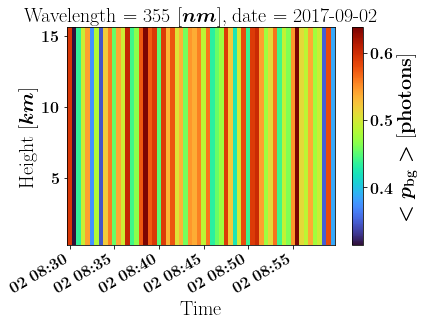

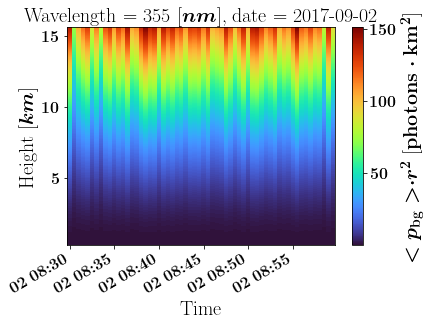

poisson STEP: 100%|██████████| 122880/122880 [00:01<00:00, 104258.02it/s]


Elapsed time is 1.189728 seconds.


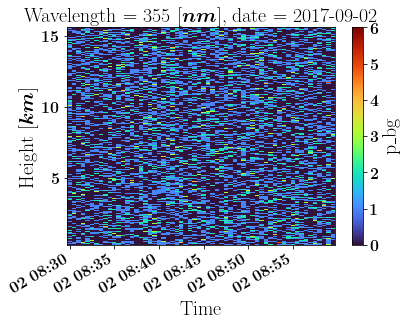

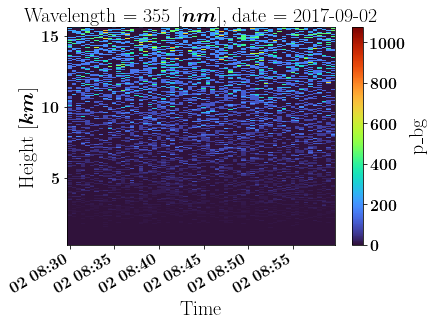

In [73]:
nc_path = os.path.join(station.nn_source_data, df_gen_train.bg_path.iloc[55])
print(nc_path)
bg_ds = xr_utils.load_dataset(ncpath=nc_path)
bg_ds.p_bg.plot(cmap='turbo')
plt.show()
bg_ds.p_bg_r2.plot(cmap='turbo')
plt.show()
p_bg_da = apply_poisson_xr(bg_ds.p_bg)
p_bg_da.plot(cmap='turbo')
plt.show()
range_corr = calc_range_corr_xr(station,p_bg_da)
range_corr.plot(cmap='turbo')
plt.show()